# Preprocessing

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [42]:
machine_failure = pd.read_csv('data/ai4i2020.csv')

In [43]:
machine_failure.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Pipeline para preprocesamiento

## Quita columnas de ID

In [44]:
machine_failure = machine_failure.drop(columns=['UDI', 'Product ID'])

## One-Hot Encoding para variables categóricas

In [45]:
machine_failure = pd.get_dummies(machine_failure, drop_first=True, dtype=int)

In [46]:
machine_failure.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,1
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1,0


## Label Encoding para clase de falla

Vamos a definir nuestro propio transformador para las clases de fallas.

Los tipos de fallas estarán denotadas de la siguiente manera:
- `0` - `No hay falla`.
- `1` - `TWF` (Tool Wear Failure).
- `2` - `HDF` (Heat Dissipation Failure).
- `3` - `PWF` (Power Failure).
- `4` - `OSF` (Overstrain Failure).
- `5` - `RNF` (Random Normal Failure).
- `6` - `Múltiples fallas`.

El criterio para el procesamiento de las fallas será el siguiente:
1. Se ignora la columna `Machine failure`.
2. Si tiene una sola falla, se le asigna la falla correspondiente dada la columna.
3. Si tiene dos fallas y una de estas es `RNF`, se asigna la que no es `RNF`. Esto debido a que la falla `RNF` es aleatoria y por lo tanto tiene precedencia una falla que tenga causa establecida.
4. Si tiene dos fallas y ninguna es `RNF`, se asigna `6` (Múltiples fallas).
5. Si tiene más de dos fallas, se asigna `6` (Múltiples fallas).

La variable objetivo será procesada en una nueva columna llamada `Failure type`.

In [47]:
# Variable to determine the number of activated flags
machine_failure['Flags quantity'] = (
    machine_failure['TWF']
    + machine_failure['HDF']
    + machine_failure['PWF']
    + machine_failure['OSF']
    + machine_failure['RNF']
)

In [48]:
machine_failure['Failure type'] = 0

In [49]:
machine_failure['Failure type'].value_counts()

Failure type
0    10000
Name: count, dtype: int64

### Asignar fallas únicas

In [50]:
one_failure_mask = machine_failure['Flags quantity'] == 1

In [51]:
machine_failure.loc[one_failure_mask & (machine_failure['TWF'] == 1), 'Failure type'] = 1
machine_failure.loc[one_failure_mask & (machine_failure['HDF'] == 1), 'Failure type'] = 2
machine_failure.loc[one_failure_mask & (machine_failure['PWF'] == 1), 'Failure type'] = 3
machine_failure.loc[one_failure_mask & (machine_failure['OSF'] == 1), 'Failure type'] = 4
machine_failure.loc[one_failure_mask & (machine_failure['RNF'] == 1), 'Failure type'] = 5

In [52]:
machine_failure['Failure type'].value_counts()

Failure type
0    9676
2     106
3      80
4      78
1      42
5      18
Name: count, dtype: int64

### Asignar fallas que están acompañadas de `RNF`

In [53]:
two_failure_mask = machine_failure['Flags quantity'] == 2
two_failure_with_rnf_mask = two_failure_mask & (machine_failure['RNF'] == 1)

In [54]:
machine_failure[two_failure_with_rnf_mask]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M,Flags quantity,Failure type
3611,301.7,310.9,1405,46.4,207,1,1,0,0,0,1,1,0,2,0


Solo existe una correspondiente a una falla `TWF`. Aún así procesaremos todas las fallas.

In [55]:
machine_failure.loc[two_failure_with_rnf_mask & (machine_failure['TWF'] == 1), 'Failure type'] = 1
machine_failure.loc[two_failure_with_rnf_mask & (machine_failure['HDF'] == 1), 'Failure type'] = 2
machine_failure.loc[two_failure_with_rnf_mask & (machine_failure['PWF'] == 1), 'Failure type'] = 3
machine_failure.loc[two_failure_with_rnf_mask & (machine_failure['OSF'] == 1), 'Failure type'] = 4

In [56]:
machine_failure['Failure type'].value_counts()

Failure type
0    9675
2     106
3      80
4      78
1      43
5      18
Name: count, dtype: int64

### Asignar múltiples fallas en las que hay dos fallas sin `RNF`

In [57]:
two_failure_without_rnf_mask = (machine_failure['Flags quantity'] == 2) & (machine_failure['RNF'] == 0)

In [58]:
machine_failure[two_failure_without_rnf_mask]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M,Flags quantity,Failure type
69,298.9,309.0,1410,65.7,191,1,0,0,1,1,0,1,0,2,0
1324,298.8,310.1,1243,74.5,194,1,0,0,1,1,0,0,1,2,0
1496,298.0,308.7,1268,69.4,189,1,0,0,1,1,0,1,0,2,0
3854,302.4,311.0,1338,67.6,194,1,0,0,1,1,0,1,0,2,0
3943,302.3,311.4,1333,66.7,205,1,0,0,1,1,0,1,0,2,0
4254,302.6,311.0,1284,68.0,114,1,0,1,1,0,0,1,0,2,0
4342,301.7,309.8,1284,68.2,111,1,0,1,1,0,0,0,1,2,0
4370,302.0,309.9,1308,57.6,197,1,0,1,0,1,0,1,0,2,0
4383,301.7,309.5,1298,65.5,229,1,0,1,0,1,0,1,0,2,0
4417,302.6,310.4,1365,66.8,80,1,0,1,1,0,0,1,0,2,0


In [59]:
# 6 is the class for multi-failure
machine_failure.loc[two_failure_without_rnf_mask, 'Failure type'] = 6

In [60]:
machine_failure['Failure type'].value_counts()

Failure type
0    9653
2     106
3      80
4      78
1      43
6      22
5      18
Name: count, dtype: int64

### Asignar múltiples fallas en las que hay más de dos fallas

In [61]:
multi_failure_mask = machine_failure['Flags quantity'] > 2

In [62]:
machine_failure[multi_failure_mask]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M,Flags quantity,Failure type
5909,300.7,310.2,1364,65.3,208,1,1,0,1,1,0,0,0,3,0


Solo existe un registro.

In [63]:
machine_failure.loc[multi_failure_mask, 'Failure type'] = 6

In [64]:
machine_failure['Failure type'].value_counts()

Failure type
0    9652
2     106
3      80
4      78
1      43
6      23
5      18
Name: count, dtype: int64

In [65]:
machine_failure['Failure type'].value_counts(normalize=True) * 100.

Failure type
0    96.52
2     1.06
3     0.80
4     0.78
1     0.43
6     0.23
5     0.18
Name: proportion, dtype: float64

In [25]:
machine_failure['Failure type'].value_counts().sum()

10000

In [66]:
proporcion = pd.DataFrame(machine_failure['Failure type'].value_counts(normalize=True) * 100.)

In [69]:
proporcion[proporcion.index != 0].sum()

proportion    3.48
dtype: float64

In [75]:
proporcion

,proportion
Failure type,
0,96.52
2,1.06
3,0.80
4,0.78
1,0.43
6,0.23
5,0.18


Verificamos que tenemos 10,000 registros como debe ser.

In [71]:
import seaborn as sns
from matplotlib import pyplot as plt

<Axes: xlabel='proportion', ylabel='count'>

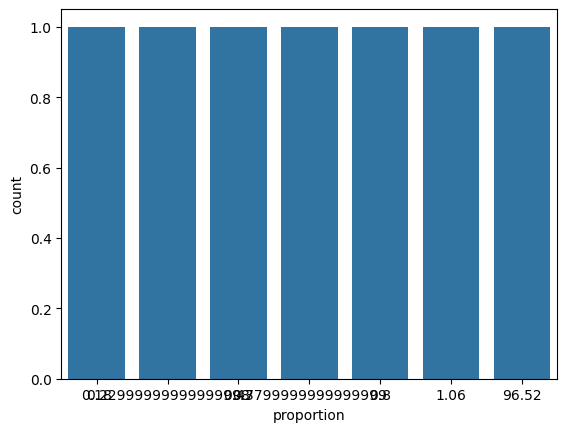

In [80]:
sns.catplot(data=proporcion.reset_index(), x='Failure type', y='')

## Limpieza de columnas innecesarias.

In [26]:
columns_to_drop = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Flags quantity', 'Machine failure']

In [27]:
machine_failure = machine_failure.drop(columns=columns_to_drop)

## Recreamos nueva columna `Machine failure`

In [28]:
machine_failure['Machine failure'] = (machine_failure['Failure type'] != 0).astype(int)

### Resultado parcial

In [29]:
machine_failure.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_L,Type_M,Failure type,Machine failure
0,298.1,308.6,1551,42.8,0,0,1,0,0
1,298.2,308.7,1408,46.3,3,1,0,0,0
2,298.1,308.5,1498,49.4,5,1,0,0,0
3,298.2,308.6,1433,39.5,7,1,0,0,0
4,298.2,308.7,1408,40.0,9,1,0,0,0


## Nota importante

Es importante que solo se use la columna `Failure type` o `Machine failure` para el entrenamiento del modelo. Si se usan ambas, esto contiene data leakage y el modelo no será capaz de generalizar correctamente.

Por lo tanto, se pueden ejecutar dos tareas de predicción diferentes:
1. Predecir si la máquina va o no va a fallar dado el estado actual.
2. Predecir el tipo de falla que va a ocurrir.

## Train-Test splitting

In [30]:
X = machine_failure.drop(columns=['Failure type', 'Machine failure'])
y = machine_failure[['Machine failure', 'Failure type']]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=95, stratify=y['Failure type'])

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 7) (2000, 7) (8000, 2) (2000, 2)


In [32]:
display(X_train.head())
display(X_test.head())

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_L,Type_M
2367,299.3,308.5,1496,39.4,80,0,1
761,296.7,307.8,1646,34.6,238,1,0
240,298.0,308.1,1339,51.6,197,0,1
1344,298.5,310.1,1809,28.9,20,1,0
7300,300.2,310.6,1431,42.3,113,1,0


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_L,Type_M
2950,300.7,309.5,1445,46.4,24,0,1
2136,299.2,308.9,1588,41.5,150,1,0
9207,297.9,308.8,1386,48.6,75,1,0
6424,300.3,310.0,1409,43.2,9,0,1
8168,299.7,311.1,1690,30.6,148,1,0


In [33]:
display(y_train.head())
display(y_test.head())

,Machine failure,Failure type
2367,0,0
761,0,0
240,0,0
1344,0,0
7300,0,0


,Machine failure,Failure type
2950,0,0
2136,0,0
9207,0,0
6424,0,0
8168,0,0


In [34]:
y['Failure type'].value_counts(normalize=True)

Failure type
0    0.9652
2    0.0106
3    0.0080
4    0.0078
1    0.0043
6    0.0023
5    0.0018
Name: proportion, dtype: float64

In [35]:
y_train['Failure type'].value_counts(normalize=True)

Failure type
0    0.965250
2    0.010625
3    0.008000
4    0.007750
1    0.004250
6    0.002250
5    0.001875
Name: proportion, dtype: float64

## StandardScaler para variables numéricas

Primero separamos las variables categóricas de las numéricas.

In [36]:
standard_scaler_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

In [37]:
X_train_categorical = X_train.drop(columns=standard_scaler_columns)
X_test_categorical = X_test.drop(columns=standard_scaler_columns)

In [38]:
X_train_numerical = X_train[standard_scaler_columns].copy()
X_test_numerical = X_test[standard_scaler_columns].copy()

In [39]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_numerical)

StandardScaler()

In [40]:
standard_scaler.feature_names_in_

array(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype=object)

In [41]:
X_train_numerical_scaled = standard_scaler.transform(X_train[standard_scaler_columns])
X_test_numerical_scaled = standard_scaler.transform(X_test[standard_scaler_columns])

In [42]:
X_train_numerical_scaled[0:5,:]

array([[-0.3546424 , -1.01467441, -0.23903879, -0.05909652, -0.44016226],
       [-1.65120996, -1.4863222 ,  0.59359995, -0.53931201,  2.04509719],
       [-1.00292618, -1.28418744, -1.110534  ,  1.1614512 ,  1.4001881 ],
       [-0.75358626,  0.06337767,  1.49840072, -1.10956791, -1.38393167],
       [ 0.09416945,  0.40026895, -0.59984891,  0.23103368,  0.07891092]])

In [43]:
X_test_numerical_scaled[0:5,:]

array([[ 0.34350937, -0.34089186, -0.52213596,  0.64121774, -1.32101371],
       [-0.40451038, -0.74516139,  0.27164631,  0.15099776,  0.66090206],
       [-1.05279416, -0.81253965, -0.84964053,  0.86131651, -0.51880971],
       [ 0.14403744, -0.00400058, -0.72196926,  0.32107408, -1.55695606],
       [-0.15517046,  0.73716022,  0.83784065, -0.93949159,  0.62944308]])

In [44]:
# Check if the scaling was done correctly
print("For the training set")
print(X_train_numerical_scaled.mean(axis=0))
print(X_train_numerical_scaled.std(axis=0))
print()
print("For the test set")
print(X_test_numerical_scaled.mean(axis=0))
print(X_test_numerical_scaled.std(axis=0))

For the training set
[ 2.22808438e-14 -1.05595532e-14 -4.21440660e-16 -3.92130772e-16
  2.70894418e-17]
[1. 1. 1. 1. 1.]

For the test set
[-0.01554011 -0.00127176 -0.00795933 -0.00189585 -0.00253638]
[0.98702962 0.99831944 0.97544618 0.98637943 1.00596925]


In [45]:
# Check if there are null values in X_train_numerical_scaled
print(np.isnan(X_train_numerical_scaled).sum())
print(np.isnan(X_test_numerical_scaled).sum())

0
0


In [46]:
X_train_numerical_scaled = pd.DataFrame(X_train_numerical_scaled, columns=standard_scaler.feature_names_in_)
X_test_numerical_scaled = pd.DataFrame(X_test_numerical_scaled, columns=standard_scaler.feature_names_in_)

In [47]:
display(X_train_numerical_scaled.head())
display(X_test_numerical_scaled.head())

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,-0.354642,-1.014674,-0.239039,-0.059097,-0.440162
1,-1.651210,-1.486322,0.593600,-0.539312,2.045097
2,-1.002926,-1.284187,-1.110534,1.161451,1.400188
3,-0.753586,0.063378,1.498401,-1.109568,-1.383932
4,0.094169,0.400269,-0.599849,0.231034,0.078911


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.343509,-0.340892,-0.522136,0.641218,-1.321014
1,-0.404510,-0.745161,0.271646,0.150998,0.660902
2,-1.052794,-0.812540,-0.849641,0.861317,-0.518810
3,0.144037,-0.004001,-0.721969,0.321074,-1.556956
4,-0.155170,0.737160,0.837841,-0.939492,0.629443


In [48]:
# Check for null values in X_train_numerical_scaled
print("NULL VALUES CHECK")
print("For the train set")
print(X_train_numerical_scaled.isnull().sum())
print()
print("For the test set")
print(X_test_numerical_scaled.isnull().sum())

NULL VALUES CHECK
For the train set
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64

For the test set
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64


In [49]:
X_train_processed = pd.concat(
    [X_train_categorical.reset_index(drop=True),
    X_train_numerical_scaled],
    axis=1
)

In [50]:
X_train_processed.head()

,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0,1,-0.354642,-1.014674,-0.239039,-0.059097,-0.440162
1,1,0,-1.651210,-1.486322,0.593600,-0.539312,2.045097
2,0,1,-1.002926,-1.284187,-1.110534,1.161451,1.400188
3,1,0,-0.753586,0.063378,1.498401,-1.109568,-1.383932
4,1,0,0.094169,0.400269,-0.599849,0.231034,0.078911


In [51]:
# Check for null values in X_train_processed
print("NULL VALUES CHECK")
print("For the train set")
print(X_train_processed.isnull().sum())

NULL VALUES CHECK
For the train set
Type_L                     0
Type_M                     0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64


In [52]:
X_test_processed = pd.concat(
    [X_test_categorical.reset_index(drop=True),
    X_test_numerical_scaled],
    axis=1
)

In [53]:
X_test_processed.head()

,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0,1,0.343509,-0.340892,-0.522136,0.641218,-1.321014
1,1,0,-0.404510,-0.745161,0.271646,0.150998,0.660902
2,1,0,-1.052794,-0.812540,-0.849641,0.861317,-0.518810
3,0,1,0.144037,-0.004001,-0.721969,0.321074,-1.556956
4,1,0,-0.155170,0.737160,0.837841,-0.939492,0.629443


In [54]:
# Check for null values in X_train_processed
print("NULL VALUES CHECK")
print("For the train set")
print(X_test_processed.isnull().sum())

NULL VALUES CHECK
For the train set
Type_L                     0
Type_M                     0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64


# Guardar datos preprocesados

In [65]:
X_train_processed.to_csv('data/X_train.csv', index=False)
X_test_processed.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

# Testear módulo de preprocessing

El módulo `mltools/preprocessing.py` contiene la clase `PreprocessingPipeline` la cual encapsula el preprocesamiento de los datos como se muestra abajo.

In [55]:
from mltools import preprocessing

In [56]:
pipeline = preprocessing.PreprocessingPipeline()

In [57]:
machine_failure_data = pd.read_csv('data/ai4i2020.csv')

In [58]:
pipeline.fit(machine_failure_data)

In [60]:
X_train_pip, X_test_pip, y_train_pip, y_test_pip = pipeline.transform_split()

In [63]:
print(X_train_processed.equals(X_train_pip))
print(X_test_processed.equals(X_test_pip))
print(y_train.equals(y_train_pip))
print(y_test.equals(y_test_pip))

True
True
True
True


# Procesamiento de datos extendido
Con esto añadimos dos nuevos términos:
- `Temperature difference [K]`: Correspondiente a la diferencia de las dos variables de temperatura.
- `Rotational power`: Correspondiente a un término de interacción (producto) entre `Rotational speed [rpm]` y `Torque [Nm]`.

El pipeline de preprocesamiento extendido ya se encuentra en el módulo `mltools.preprocessing`. Esta es la ventaja de encapsular el preprocesamiento en una clase. Lo que se hizo fue modificar la clase para que pudiera recibir un parámetro `interaction_terms`. Este parámetro es un booleano que indica si se deben añadir los términos de interacción o no. Su uso se demuestra en el siguiente código.

In [4]:
import pandas as pd

from mltools import preprocessing

In [2]:
pipeline = preprocessing.PreprocessingPipeline()

In [5]:
machine_failure_data = pd.read_csv('data/ai4i2020.csv')

In [6]:
pipeline.fit(machine_failure_data, interaction_terms=True)

In [7]:
X_train_extended, X_test_extended, y_train_extended, y_test_extended = pipeline.transform_split()

In [8]:
X_train_extended.head()

,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temperature difference [K],Rotational power
0,0,1,-0.354642,-1.014674,-0.239039,-0.059097,-0.440162,-0.792467,-0.100567
1,1,0,-1.651210,-1.486322,0.593600,-0.539312,2.045097,1.102016,-0.295095
2,0,1,-1.002926,-1.284187,-1.110534,1.161451,1.400188,0.104919,0.891225
3,1,0,-0.753586,0.063378,1.498401,-1.109568,-1.383932,1.600564,-0.751564
4,1,0,0.094169,0.400269,-0.599849,0.231034,0.078911,0.404048,0.054690


## Guardamos datos extendidos

In [40]:
X_train_extended.to_csv('data/X_train_extended.csv', index=False)
X_test_extended.to_csv('data/X_test_extended.csv', index=False)

In [10]:
y_train_extended.value_counts()

Machine failure  Failure type
0                0               7722
1                2                 85
                 3                 64
                 4                 62
                 1                 34
                 6                 18
                 5                 15
Name: count, dtype: int64